<a href="https://colab.research.google.com/github/zzaeyun/ESAA22-2/blob/main/%ED%8C%8C%EC%9D%B4%EC%8D%AC%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D%EC%99%84%EB%B2%BD%EA%B0%80%EC%9D%B4%EB%93%9C_252to277.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **08 분류 실습 - 캐글 산탄데르 고객 만족 예측**

- 고객 만족 여부를 XGBoost LightGBM을 활용한 예측
- 1이면 불만을 가진 고객, 0이면 만족한 고객
- 모델 성능 평가는 RPC-AUC(ROC 곡선 영역)로 평가

---

### **데이터 전처리**

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

cust_df=pd.read_csv('/train_santander.csv', encoding='latin-1')
print('dataset shape:', cust_df.shape)
cust_df.head()

dataset shape: (76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


In [5]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


In [6]:
print(cust_df['TARGET'].value_counts())
unsatisfied_cnt=cust_df[cust_df['TARGET']==1].TARGET.count()
total_cnt=cust_df.TARGET.count()
print('unsatisfied 비율은 {0:.2f}'.format((unsatisfied_cnt/total_cnt)))

0    73012
1     3008
Name: TARGET, dtype: int64
unsatisfied 비율은 0.04


In [7]:
cust_df.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


var3 칼럼의 경우 특정 예외 값을 -99999로 변환한 것으로 보이는데 편차가 너무 심하므로 가장 많은 값인 2로 변경

In [8]:
cust_df['var3'].replace(-99999,2,inplace=True)
cust_df.drop('ID', axis=1, inplace=True)

X_features=cust_df.iloc[:,:-1]
y_labels=cust_df.iloc[:,-1]
print('피처 데이터 shape:{0}'.format(X_features.shape))

피처 데이터 shape:(76020, 369)


In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test=train_test_split(X_features, y_labels, test_size=0.2, random_state=0)
train_cnt=y_train.count()
test_cnt=y_test.count()

print('학습 세트 Shape:{0}, 테스트 세트 Shape:{1}'.format(X_train.shape, X_test.shape))

print('학습 세트 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)

학습 세트 Shape:(60816, 369), 테스트 세트 Shape:(15204, 369)
학습 세트 레이블 값 분포 비율
0    0.960964
1    0.039036
Name: TARGET, dtype: float64

 테스트 세트 레이블 값 분포 비율
0    0.9583
1    0.0417
Name: TARGET, dtype: float64


### **XGBoost 모델 학습과 하이퍼 파라이터 튜닝**

In [10]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

xgb_clf=XGBClassifier(n_estimators=500, random_state=156)

xgb_clf.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='auc', eval_set=[(X_train, y_train), (X_test, y_test)])

xgb_roc_score=roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1], average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.799928	validation_1-auc:0.803548
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.802222	validation_1-auc:0.805222
[2]	validation_0-auc:0.80819	validation_1-auc:0.813162
[3]	validation_0-auc:0.8127	validation_1-auc:0.813243
[4]	validation_0-auc:0.81648	validation_1-auc:0.816979
[5]	validation_0-auc:0.816018	validation_1-auc:0.816629
[6]	validation_0-auc:0.816474	validation_1-auc:0.817776
[7]	validation_0-auc:0.818148	validation_1-auc:0.818464
[8]	validation_0-auc:0.81806	validation_1-auc:0.818295
[9]	validation_0-auc:0.817039	validation_1-auc:0.818087
[10]	validation_0-auc:0.818318	validation_1-auc:0.818749
[11]	validation_0-auc:0.818711	validation_1-auc:0.818521
[12]	validation_0-auc:0.818673	validation_1-auc:0.818516
[13]	validation_0-auc:0.819156	validation_1-auc:0.818998
[14]	validation_0-auc:0.819847	validation_1-auc:0.81999
[15

하이퍼 파라미터 변경해보기

In [12]:
from sklearn.model_selection import GridSearchCV

xgb_clf=XGBClassifier(n_estimators=100)

params={'max_depth':[5,7], 'min_child_weight':[1,3], 'colsample_bytree':[0.5,0.75]}

gridcv=GridSearchCV(xgb_clf, param_grid=params, cv=3)
gridcv.fit(X_train, y_train, early_stopping_rounds=30, eval_metric='auc', eval_set=[(X_train, y_train), (X_test, y_test)])

print('GridSearchCV 최적 파라미터:', gridcv.best_params_)

xgb_roc_score=roc_auc_score(y_test, gridcv.predict_proba(X_test)[:,1], average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.715421	validation_1-auc:0.722463
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.802772	validation_1-auc:0.807648
[2]	validation_0-auc:0.800147	validation_1-auc:0.804566
[3]	validation_0-auc:0.805692	validation_1-auc:0.809325
[4]	validation_0-auc:0.814807	validation_1-auc:0.816951
[5]	validation_0-auc:0.810346	validation_1-auc:0.812634
[6]	validation_0-auc:0.810623	validation_1-auc:0.814491
[7]	validation_0-auc:0.818556	validation_1-auc:0.820561
[8]	validation_0-auc:0.822006	validation_1-auc:0.823553
[9]	validation_0-auc:0.820433	validation_1-auc:0.821292
[10]	validation_0-auc:0.826212	validation_1-auc:0.825279
[11]	validation_0-auc:0.830077	validation_1-auc:0.827817
[12]	validation_0-auc:0.832328	validation_1-auc:0.828775
[13]	validation_0-auc:0.832008	validation_1-auc:0.827865
[14]	validation_0-auc:0.830319	validation_1-auc:0.82674

In [13]:
#n_estimators는 1000으로 증가, learning_rate=0.02로 감소, reg_alpha=0.03으로 추가함

xgb_clf=XGBClassifier(n_estimators=1000, random_state=156, learning_rate=0.02, max_depth=7, 
                      min_child_weight=1, colsample_bytree=0.75, reg_alpha=0.03)

xgb_clf.fit(X_train, y_train, early_stopping_rounds=200,
            eval_metric='auc', eval_set=[(X_train, y_train), (X_test, y_test)])

xgb_roc_score=roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1], average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.822918	validation_1-auc:0.815289
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 200 rounds.
[1]	validation_0-auc:0.8269	validation_1-auc:0.81662
[2]	validation_0-auc:0.831833	validation_1-auc:0.820425
[3]	validation_0-auc:0.835682	validation_1-auc:0.82505
[4]	validation_0-auc:0.838007	validation_1-auc:0.826108
[5]	validation_0-auc:0.837772	validation_1-auc:0.827311
[6]	validation_0-auc:0.837942	validation_1-auc:0.826909
[7]	validation_0-auc:0.838344	validation_1-auc:0.827175
[8]	validation_0-auc:0.839621	validation_1-auc:0.828217
[9]	validation_0-auc:0.839657	validation_1-auc:0.827852
[10]	validation_0-auc:0.841509	validation_1-auc:0.829012
[11]	validation_0-auc:0.84092	validation_1-auc:0.828037
[12]	validation_0-auc:0.841022	validation_1-auc:0.828533
[13]	validation_0-auc:0.841312	validation_1-auc:0.828333
[14]	validation_0-auc:0.845194	validation_1-auc:0.834113
[1

### **피처의 중요도 그래프**

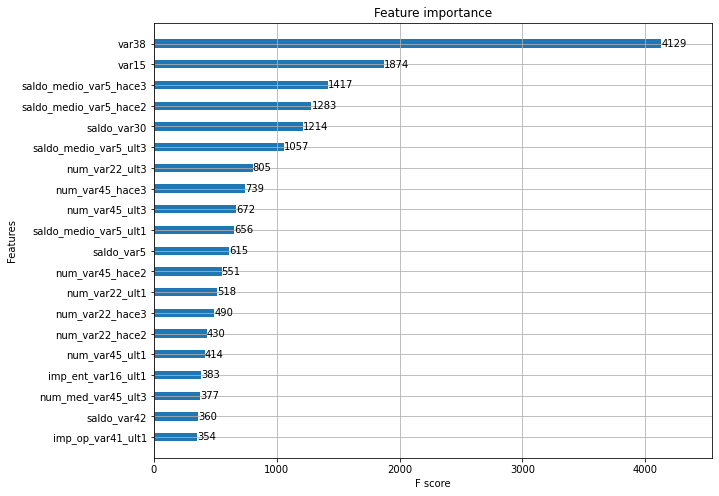

In [14]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax=plt.subplots(1,1,figsize=(10,8))
plot_importance(xgb_clf, ax=ax, max_num_features=20, height=0.4)

### **LightGBM 모델 학습과 하이퍼 파라미터 튜닝**

In [16]:
from lightgbm import LGBMClassifier

lgbm_clf=LGBMClassifier(n_estimators=500)

evals=[(X_test, y_test)]
lgbm_clf.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='auc', eval_set=evals, verbose=True)

lgbm_roc_score=roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1], average='macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[1]	valid_0's binary_logloss: 0.165046	valid_0's auc: 0.817384
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.16	valid_0's auc: 0.81863
[3]	valid_0's binary_logloss: 0.15628	valid_0's auc: 0.827229
[4]	valid_0's binary_logloss: 0.153407	valid_0's auc: 0.832107
[5]	valid_0's binary_logloss: 0.151198	valid_0's auc: 0.834741
[6]	valid_0's binary_logloss: 0.149292	valid_0's auc: 0.83469
[7]	valid_0's binary_logloss: 0.147809	valid_0's auc: 0.835979
[8]	valid_0's binary_logloss: 0.146438	valid_0's auc: 0.837682
[9]	valid_0's binary_logloss: 0.145448	valid_0's auc: 0.838193
[10]	valid_0's binary_logloss: 0.144653	valid_0's auc: 0.838599
[11]	valid_0's binary_logloss: 0.143949	valid_0's auc: 0.838227
[12]	valid_0's binary_logloss: 0.143381	valid_0's auc: 0.837881
[13]	valid_0's binary_logloss: 0.142806	valid_0's auc: 0.838123
[14]	valid_0's binary_logloss: 0.142267	valid_0's auc: 0.838551
[15]	valid_0's binary_logloss: 0.14188	valid_0's auc: 0.8

In [19]:
from sklearn.model_selection import GridSearchCV

lgbm_clf=LGBMClassifier(n_eatimator=200)
params={'num_leaves':[32,64],
        'max_depth':[128,160],
        'min_child_samples':[60,100],
        'subsample':[0.8,1]}

gridcv=GridSearchCV(lgbm_clf, param_grid=params, cv=3)
gridcv.fit(X_train, y_train, early_stopping_rounds=30, eval_metric='auc',
           eval_set=[(X_train, y_train), (X_test, y_test)])

print('GridSearchCV 최적 파라미터:', gridcv.best_params_)
lgbm_roc_score=roc_auc_score(y_test, gridcv.predict_proba(X_test)[:,1], average='macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[1]	valid_0's binary_logloss: 0.156085	valid_0's auc: 0.820235	valid_1's binary_logloss: 0.164992	valid_1's auc: 0.81613
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's binary_logloss: 0.150951	valid_0's auc: 0.825778	valid_1's binary_logloss: 0.159874	valid_1's auc: 0.821835
[3]	valid_0's binary_logloss: 0.147167	valid_0's auc: 0.832192	valid_1's binary_logloss: 0.156391	valid_1's auc: 0.827305
[4]	valid_0's binary_logloss: 0.144132	valid_0's auc: 0.837507	valid_1's binary_logloss: 0.15332	valid_1's auc: 0.8334
[5]	valid_0's binary_logloss: 0.141652	valid_0's auc: 0.842275	valid_1's binary_logloss: 0.150954	valid_1's auc: 0.836036
[6]	valid_0's binary_logloss: 0.139662	valid_0's auc: 0.844971	valid_1's binary_logloss: 0.149041	valid_1's auc: 0.838026
[7]	valid_0's binary_logloss: 0.138002	valid_0's auc: 0.846612	valid_1's binary_logloss: 0.147504	valid_1's auc: 0.837776
[8]	valid_0's binary_logloss: 0.136579	valid_0's auc: 0.848539	valid_1's binary_logloss:

In [20]:
lgbm_clf=LGBMClassifier(n_estimators=1000, num_leaves=32, sumbsample=0.8, min_child_samples=100, max_depth=128)
evals=[(X_test, y_test)]
lgbm_clf.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='auc', eval_set=evals, verbose=True)

lgbm_roc_score=roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1], average='macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[1]	valid_0's binary_logloss: 0.165016	valid_0's auc: 0.819488
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.159711	valid_0's auc: 0.822387
[3]	valid_0's binary_logloss: 0.156068	valid_0's auc: 0.829542
[4]	valid_0's binary_logloss: 0.153141	valid_0's auc: 0.834917
[5]	valid_0's binary_logloss: 0.150804	valid_0's auc: 0.837871
[6]	valid_0's binary_logloss: 0.148876	valid_0's auc: 0.839548
[7]	valid_0's binary_logloss: 0.147225	valid_0's auc: 0.841812
[8]	valid_0's binary_logloss: 0.14594	valid_0's auc: 0.842382
[9]	valid_0's binary_logloss: 0.144866	valid_0's auc: 0.842811
[10]	valid_0's binary_logloss: 0.143872	valid_0's auc: 0.843186
[11]	valid_0's binary_logloss: 0.14305	valid_0's auc: 0.843465
[12]	valid_0's binary_logloss: 0.142376	valid_0's auc: 0.843222
[13]	valid_0's binary_logloss: 0.141783	valid_0's auc: 0.843564
[14]	valid_0's binary_logloss: 0.141419	valid_0's auc: 0.843389
[15]	valid_0's binary_logloss: 0.141	valid_0's auc: 

## **09 분류 실습 - 캐글 신용카드 사기 검출**

- Class 속성은 매우 불균형: 0, 1로 분류되는데 0이 사기가 아닌 정상적인 신용카드 트랜잭션 데이터, 1은 신용카드 사기 트랜잭션 의미
- 0.172%만 사기 트랜잭션


---

### **언더 샘플링과 오버 샘플링의 이해**

- 일방적으로 정상 레이블로 치우친 학습을 수행해 제대로 된 이상 데이터 검출이 어려워지기 쉬움
- 문제점을 해결하기 위해 적절한 학습데이터 확보
- 오버 샘플링과 언더 샘플링 (오버 샘플링 방식이 더 유리한 경우가 많아 더 많이 사용됨)

  - 언더 샘플링은 데이터가 적은 데이터 세트 수준으로 감소시키는 방식
  - 오버 샘플링은 이상 데이터와 같이 적은 데이터 세트를 증식하여 학습을 위한 충분한 데이터를 확보

SMOTE를 구현한 대표적 파이썬 패키지: imbalanced-learn

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

card_df=pd.read_csv('/creditcard.csv')
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [80]:
#불필요한 Time 피처만 삭제

from sklearn.model_selection import train_test_split

def get_preprocessed_df(df=None):
  df_copy=df.copy()
  df_copy.drop('Time', axis=1, inplace=True)
  return df_copy

In [99]:
def get_train_test_dataset(df=None):
  df_copy=get_preprocessed_df(df)
  X_features=df_copy.iloc[:,:-1]
  y_target=df_copy.iloc[:,-1]

  X_train, X_test, y_train, y_test=train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)
  return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test=get_train_test_dataset(card_df)

In [64]:
#레이블 값 비율이 비슷하게 분할 되었는지 확인
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0]*100)
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0]*100)

학습 데이터 레이블 값 비율
0    99.827451
1     0.172549
Name: Class, dtype: float64
테스트 데이터 레이블 값 비율
0    99.826785
1     0.173215
Name: Class, dtype: float64


In [65]:
#get_clf_eval( ) 함수를 적용하여 예측 성능 평가

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score
#confusion matrix, accuracy, precision, recall 등 다양한 평가 호출: **get_clf_eval( )**

def get_clf_eval(y_test, pred, pred_proba=None):
  confusion=confusion_matrix(y_test, pred)
  accuracy=accuracy_score(y_test, pred)
  precision=precision_score(y_test, pred)
  recall=recall_score(y_test, pred)
  f1=f1_score(y_test, pred)

  roc_auc=roc_auc_score(y_test, pred_proba)
  print('오차 행렬')
  print(confusion)

  print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC: {4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [66]:
from sklearn.linear_model import LogisticRegression

lr_clf=LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred=lr_clf.predict(X_test)
lr_pred_proba=lr_clf.predict_proba(X_test)[:,1]

get_clf_eval(y_test, lr_pred, lr_pred_proba)

오차 행렬
[[85281    14]
 [   56    92]]
정확도: 0.9992, 정밀도: 0.8679, 재현율: 0.6216, F1: 0.7244, AUC: 0.9609


In [84]:
#인자로 사이킷런의 Estimator 객체와 학습/테스트 데이터 세트를 입력 받아서 학습/예측/평가 수행
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
  model.fit(ftr_train, tgt_train)
  pred=model.predict(ftr_test)
  pred_proba=model.predict_proba(ftr_test)[:,1]
  get_clf_eval(tgt_test, pred, pred_proba)

In [68]:
from lightgbm import LGBMClassifier

lgbm_clf=LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

오차 행렬
[[85289     6]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9492, 재현율: 0.7568, F1: 0.8421, AUC: 0.9797


### **데이터 분포도 변환 후 모델 학습/예측/평가**

Amount 피처의 분포도를 확인

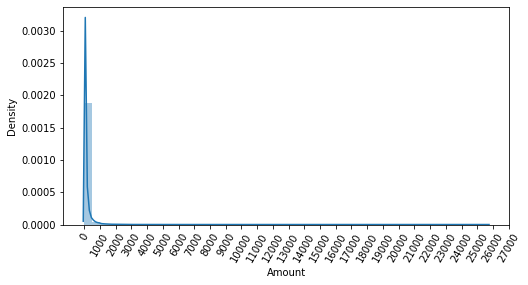

In [69]:
import seaborn as sns
plt.figure(figsize=(8,4))
plt.xticks(range(0,30000,1000), rotation=60)
sns.distplot(card_df['Amount'])

In [70]:
from sklearn.preprocessing import StandardScaler
#사이킷런의 StandardScaler를 이용해 정규 분포 형태로 Amount 피처값 변환하는 로직으로 수정
def get_preprocessed_df(df=None):
  df_copy=df
  scaler=StandardScaler()
  amount_n=scaler.fit_transform(df_copy['Amount'].values.reshape(-1,1))
  df_copy.insert(0, 'Amount_Scaled', amount_n)
  df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
  return df_copy

In [71]:
X_train, X_test, y_train, y_test =get_train_test_dataset(card_df)

print('#### 로지스틱 회귀 예측 성능 ###')
lr_clf=LogisticRegression()
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

#### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8654, 재현율: 0.6081, F1: 0.7143, AUC: 0.9702
오차 행렬
[[85289     6]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9492, 재현율: 0.7568, F1: 0.8421, AUC: 0.9773


In [83]:
#로그 변환 수행

def get_preprocessed_df(df=None):
  df_copy=df
  amount_n=np.log1p(df_copy['Amount'])
  df_copy.insert(0, 'Amount_Scaled', amount_n)
  df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
  return df_copy

In [88]:
X_train, X_test, y_train, y_test=get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)
print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85283    12]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8812, 재현율: 0.6014, F1: 0.7149, AUC: 0.9727
### LightGBM 예측 성능 ###
오차 행렬
[[85290     5]
 [   35   113]]
정확도: 0.9995, 정밀도: 0.9576, 재현율: 0.7635, F1: 0.8496, AUC: 0.9786


### **이상치 데이터 제거 후 모델 학습/예측/평가**

- 이상치로 인해 머신러닝 모델의 성능에 영향을 받는 경우가 발생하기 쉬움
- IQR 방식을 적용하여 이상치를 찾는 방법 사용
- IQR은 사분위 값의 편차를 이용하는 기법으로 박스 플롯 방식으로 시각화

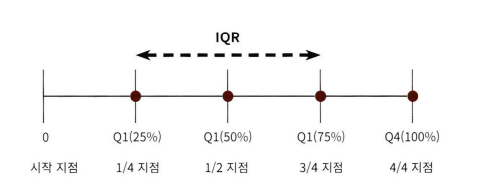

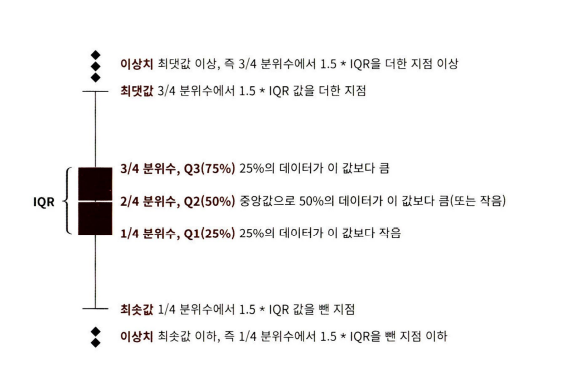

이상치 데이터를 IQR을 이용하여 제거하기
- 상관성이 높은 피처들을 위주로 이상치를 검출하는 것이 좋음
- DataFrame의 corr( )을 이용해 각 피처별로 상관도를 구한 뒤 시본의 heatmap으로 시각화

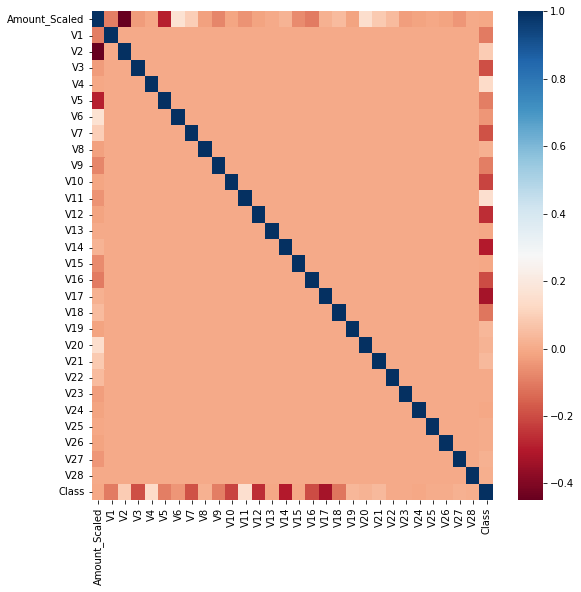

In [89]:
import seaborn as sns

plt.figure(figsize=(9,9))
corr=card_df.corr()
sns.heatmap(corr, cmap='RdBu')

cmap을 RdBu로 설정하여 양의 상관관게가 높을 수록 색깔이 진한 파란색에 가까움, 음의 상관관계가 높을수록 진한 빨간색

In [94]:
#계산된 IQR에 1.5를 곱해서 최댓값과 최솟값 지점을 구한 뒤 최댓값보다 크거나 최솟값보다 작은 값을 이상치로 설정하고 index 반환

import numpy as np
def get_outlier(df=None, column=None, weight=1.5):
  fraud=df[df['Class']==1][column]
  quantile_25=np.percentile(fraud.values, 25)
  quantile_75=np.percentile(fraud.values, 75)

  iqr=quantile_75-quantile_25
  iqr_weight=iqr*weight
  lowest_val=quantile_25 - iqr_weight
  highest_val=quantile_75 + iqr_weight

  outlier_index=fraud[(fraud<lowest_val) | (fraud>highest_val)].index
  return outlier_index

In [95]:
outlier_index=get_outlier(df=card_df, column='V14', weight=1.5)
print('이상치 데이터 인덱스:', outlier_index)

이상치 데이터 인덱스: Int64Index([8296, 8615, 9035, 9252], dtype='int64')


In [96]:
def get_preprocessed_df(df=None):
  df_copy=df.copy()
  amount_n=np.log1p(df_copy['Amount'])
  df_copy.insert(0, 'Amount_Scaled', amount_n)
  df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
  outlier_index=get_outlier(df=card_df, column='V14', weight=1.5)
  df_copy.drop(outlier_index, axis=0, inplace=True)
  return df_copy

In [100]:
X_train, X_test, y_train, y_test=get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)
print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   48    98]]
정확도: 0.9993, 정밀도: 0.8750, 재현율: 0.6712, F1: 0.7597, AUC: 0.9743
### LightGBM 예측 성능 ###
오차 행렬
[[85291     4]
 [   25   121]]
정확도: 0.9997, 정밀도: 0.9680, 재현율: 0.8288, F1: 0.8930, AUC: 0.9831


### **SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가**

- SMOTE를 적용할 때는 반드시 학습 데이터 세트만 오버 샘플링 해야함
- 검증 데이터나 테스트 데이터 세트를 오버 샘플링할 경우 올바른 검증/테스트 불가

In [106]:
from imblearn.over_sampling import SMOTE

smote=SMOTE(random_state=0)
X_train_over, y_train_over=smote.fit_resample(X_train, y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ',X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ',X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n',pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (199362, 29) (199362,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포: 
 0    199020
1    199020
Name: Class, dtype: int64


In [108]:
#로지스틱 회귀 모델
lr_clf=LogisticRegression()

get_model_train_eval(lr_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

오차 행렬
[[82937  2358]
 [   11   135]]
정확도: 0.9723, 정밀도: 0.0542, 재현율: 0.9247, F1: 0.1023, AUC: 0.9737


In [114]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler, Binarizer

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred)
    
    print('오차행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC:{4:.4f}'
          .format(accuracy, precision, recall, f1, roc_auc))
    
# get_eval_by_threshold()
def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    # thresholds list 객체 내의 값을 차례로 iteration하면서 evaluation 수행
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print(f'임곗값: {custom_threshold}')
        get_clf_eval(y_test, custom_predict)

# precision_recall_curve_plot()
def precision_recall_curve_plot(y_test, pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행, 정밀도는 점선으로 표시
    plt.figure(figsize=(8, 6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    
    # threshold 값 X축의 scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    # X, Y축 label과 legend, grid 설정
    plt.xlabel('Threshold value')
    plt.ylabel('Precision and Recall value')
    plt.legend()
    plt.grid()

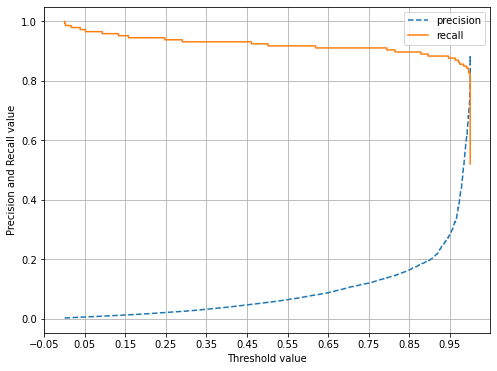

In [115]:
#로지스틱 회귀 모델 문제 확인
precision_recall_curve_plot
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])

In [116]:
lgbm_clf=LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_everage=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

오차행렬
[[85286     9]
 [   22   124]]
정확도: 0.9996, 정밀도: 0.9323, 재현율: 0.8493, F1: 0.8889, AUC:0.9246
